In [48]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [49]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [50]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [51]:
# 학습 데이터셋 불러오기
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

In [52]:
# 모델 학습 및 샘플링
# 학습을 위해 생성자와 판별자모델 초기화
# 적절한 하이퍼 파라미터 설정

# initialize Generator & Discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.to(device)

# Learning Rate
lr = 0.0002

# Optimizer for G & D
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [55]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 5000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.to(device)

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device)

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.619810] [G loss: 1.989339] [Elapsed time: 10.64s]
[Epoch 1/200] [D loss: 0.260693] [G loss: 1.173720] [Elapsed time: 20.55s]
[Epoch 2/200] [D loss: 0.300729] [G loss: 1.171016] [Elapsed time: 29.22s]
[Epoch 3/200] [D loss: 0.557267] [G loss: 0.548077] [Elapsed time: 37.47s]
[Epoch 4/200] [D loss: 0.723447] [G loss: 0.301939] [Elapsed time: 46.07s]
[Epoch 5/200] [D loss: 0.272771] [G loss: 1.395925] [Elapsed time: 58.14s]
[Epoch 6/200] [D loss: 0.360840] [G loss: 0.936666] [Elapsed time: 71.91s]
[Epoch 7/200] [D loss: 0.319158] [G loss: 3.385357] [Elapsed time: 84.44s]
[Epoch 8/200] [D loss: 0.210386] [G loss: 2.618644] [Elapsed time: 94.53s]
[Epoch 9/200] [D loss: 0.233650] [G loss: 2.961058] [Elapsed time: 105.21s]
[Epoch 10/200] [D loss: 0.207324] [G loss: 2.164872] [Elapsed time: 114.20s]
[Epoch 11/200] [D loss: 0.613283] [G loss: 0.480463] [Elapsed time: 124.18s]
[Epoch 12/200] [D loss: 0.282079] [G loss: 4.196071] [Elapsed time: 134.41s]
[Epoch 13/200] [D 

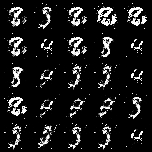

In [58]:
from IPython.display import Image

Image("Result_img/90000.png")